In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

In [2]:
unique_captions_paths = {
        "original_ds": "/ptmp/dduka/databases/ego4d/unique_captions.json",
        "temperature_0.7": "/ptmp/dduka/databases/ego4d/video_320px_15sec/lavila_captions_num_frames_4/temperature_0.7/unique_captions.json",
        "temperature_1.0": "/ptmp/dduka/databases/ego4d/video_320px_15sec/lavila_captions_num_frames_4/temperature_1.0/unique_captions.json",
}

In [5]:
# dict_keys(['number_of_total_captions', 'number_of_unique_captions', 'percentage_of_unique_captions', 'unique_captions', 'preprocess_function'])
captions_stats = {}
for key, path in unique_captions_paths.items():
    with open(path, "r") as f:
        data = json.load(f)
        
        captions_stats[key] = {
            "number_of_total_captions": data["number_of_total_captions"],
            "number_of_unique_captions": data["number_of_unique_captions"],
            "percentage_of_unique_captions": data["percentage_of_unique_captions"],
        }

In [6]:
print(captions_stats)

{'original_ds': {'number_of_total_captions': 4012544, 'number_of_unique_captions': 1288776, 'percentage_of_unique_captions': 0.32118675832589}, 'temperature_0.7': {'number_of_total_captions': 144141750, 'number_of_unique_captions': 8656234, 'percentage_of_unique_captions': 0.060053620828108445}, 'temperature_1.0': {'number_of_total_captions': 144141750, 'number_of_unique_captions': 22931175, 'percentage_of_unique_captions': 0.1590876689092508}}


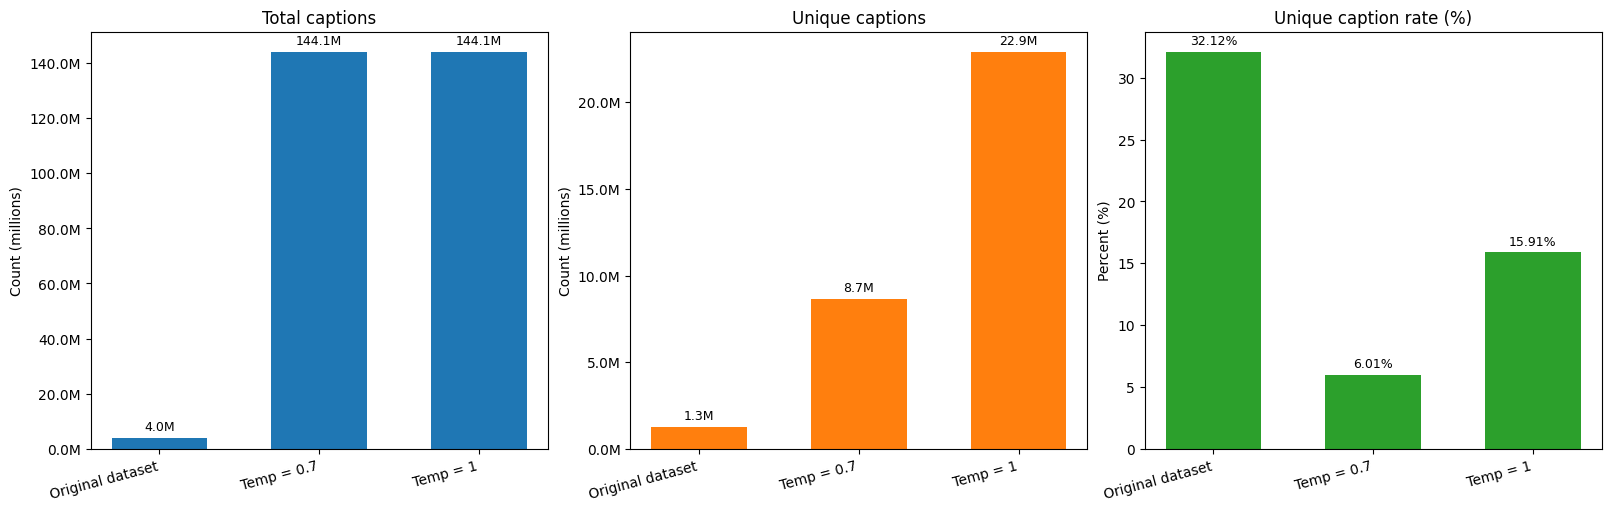

In [16]:
def pretty_label(key: str) -> str:
    if key == "original_ds":
        return "Original dataset"
    if key.startswith("temperature_"):
        try:
            t = float(key.split("_", 1)[1])
            return f"Temp = {t:g}"
        except ValueError:
            pass
    return key.replace("_", " ").title()

def sort_key(key: str):
    # Original first, then temperatures numeric, then others
    if key == "original_ds":
        return (-1, 0)
    if key.startswith("temperature_"):
        try:
            return (0, float(key.split("_", 1)[1]))
        except ValueError:
            return (0, float("inf"))
    return (1, key)

def millions_formatter(x, pos):
    return f"{x/1e6:.1f}M"

def annotate_bars(ax, bars, fmt_fn=str, dy=3):
    for b in bars:
        h = b.get_height()
        ax.annotate(
            fmt_fn(h),
            (b.get_x() + b.get_width()/2, h),
            xytext=(0, dy),
            textcoords="offset points",
            ha="center", va="bottom", fontsize=9
        )

def human_count(n: float) -> str:
    if n >= 1e9: return f"{n/1e9:.1f}B"
    if n >= 1e6: return f"{n/1e6:.1f}M"
    if n >= 1e3: return f"{n/1e3:.1f}k"
    return str(int(n))

# ---------------- Extract & order ----------------

keys   = sorted(captions_stats.keys(), key=sort_key)
labels = [pretty_label(k) for k in keys]

totals  = np.array([captions_stats[k]["number_of_total_captions"]   for k in keys], dtype=float)
uniques = np.array([captions_stats[k]["number_of_unique_captions"]  for k in keys], dtype=float)
raw_pct = np.array([captions_stats[k]["percentage_of_unique_captions"] for k in keys], dtype=float)
percents = np.where(raw_pct <= 1.0, raw_pct * 100.0, raw_pct)

x = np.arange(len(labels))
bar_width = 0.6

# Distinct colors for each metric
COL_TOTAL  = "#1f77b4"  # blue
COL_UNIQUE = "#ff7f0e"  # orange
COL_PCT    = "#2ca02c"  # green

# ---------------- Plot ----------------

fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

# Subplot 1: Total captions
ax0 = axes[0]
bars0 = ax0.bar(x, totals, width=bar_width, color=COL_TOTAL)
ax0.set_title("Total captions")
ax0.set_ylabel("Count (millions)")
ax0.set_xticks(x)
ax0.set_xticklabels(labels, rotation=15, ha="right")
ax0.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
annotate_bars(ax0, bars0, human_count)

# Subplot 2: Unique captions
ax1 = axes[1]
bars1 = ax1.bar(x, uniques, width=bar_width, color=COL_UNIQUE)
ax1.set_title("Unique captions")
ax1.set_ylabel("Count (millions)")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=15, ha="right")
ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
annotate_bars(ax1, bars1, human_count)

# Subplot 3: % unique
ax2 = axes[2]
bars2 = ax2.bar(x, percents, width=bar_width, color=COL_PCT)
ax2.set_title("Unique caption rate (%)")
ax2.set_ylabel("Percent (%)")
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=15, ha="right")
annotate_bars(ax2, bars2, lambda v: f"{v:.2f}%")

plt.show()
